In [5]:
#!pip install catboost

In [6]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
print(f"catBoost version: {cb.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")

catBoost version: 1.2.2
numpy version: 1.26.0
pandas version: 2.1.1
seaborn version: 0.12.2


In [8]:
print('Loading Properties ...')
properties2016 = pd.read_csv('properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('properties_2017.csv', low_memory = False)

print('Loading Train ...')
train2016 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

print('Loading Sample ...')
sample_submission = pd.read_csv('sample_submission.csv', low_memory = False)

print('Done ...')

Loading Properties ...
Loading Train ...
Loading Sample ...
Done ...


In [9]:
print(properties2016.shape)
print(properties2017.shape)
print(train2016.shape)
print(train2017.shape)
print(sample_submission.shape)

(2985217, 58)
(2985217, 58)
(90275, 3)
(77613, 3)
(2985217, 7)


## Exploring the csvs

In [10]:
train2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,1/1/2016
1,14366692,-0.1684,1/1/2016
2,12098116,-0.0040,1/1/2016
3,12643413,0.0218,2/1/2016
4,14432541,-0.0050,2/1/2016


In [11]:
train2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,1/1/2017
1,17052889,0.055619,1/1/2017
2,14186244,0.005383,1/1/2017
3,12177905,-0.103410,1/1/2017
4,10887214,0.006940,1/1/2017


In [12]:
properties2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [13]:
properties2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [14]:
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


## Observing sample submission parcelID order

In [15]:
sample_submission["ParcelId"].equals(properties2016["parcelid"])

True

In [16]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

False

The parcelid order in sample submission seems to follow that of 2016, thus we need to reorder 2017

### Reordering properties2017

In [17]:
properties2017 = pd.merge(sample_submission["ParcelId"], properties2017, how='left', left_on ='ParcelId',right_on='parcelid').drop("ParcelId", axis=1)
properties2017

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,110245.0,226900.0,2016.0,116655.0,3035.26,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,3.0,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,378466.0,762157.0,2016.0,383691.0,8653.10,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,NaN,NaN,201575.0,483188.0,2016.0,281613.0,5671.40,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,NaN,...,NaN,NaN,347863.0,578621.0,2016.0,230758.0,5894.36,NaN,NaN,NaN


In [18]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

True

## Splitting transaction dates into month, year (removing day)

In [19]:
def split_date(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"], dayfirst=True)
    df["transaction_year"] = df["transactiondate"].dt.year
    
#     df["transaction_month"] = df["transactiondate"].dt.month

#     the code below is used if we want to let 2017 jan start as month 13 (might be useful when we combine both years to train a model)
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month

    
#     df["transaction_day"] = df["transactiondate"].dt.day
    
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = split_date(train2016)
train2017 = split_date(train2017)

In [20]:
print(train2016.shape)
train2016.head()

(90275, 4)


,parcelid,logerror,transaction_year,transaction_month
0,11016594,0.0276,2016,1
1,14366692,-0.1684,2016,1
2,12098116,-0.0040,2016,1
3,12643413,0.0218,2016,1
4,14432541,-0.0050,2016,1


In [21]:
print(train2017.shape)
train2017.head()

(77613, 4)


,parcelid,logerror,transaction_year,transaction_month
0,14297519,0.025595,2017,13
1,17052889,0.055619,2017,13
2,14186244,0.005383,2017,13
3,12177905,-0.103410,2017,13
4,10887214,0.006940,2017,13


we can see that Jan 2017 starts as month 13

## Non-Null counts for the columns in properties.csv

In [22]:
properties2016.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   parcelid                      2985217 non-null  int64  
 1   airconditioningtypeid         811519 non-null   float64
 2   architecturalstyletypeid      6061 non-null     float64
 3   basementsqft                  1628 non-null     float64
 4   bathroomcnt                   2973755 non-null  float64
 5   bedroomcnt                    2973767 non-null  float64
 6   buildingclasstypeid           12629 non-null    float64
 7   buildingqualitytypeid         1938488 non-null  float64
 8   calculatedbathnbr             2856305 non-null  float64
 9   decktypeid                    17096 non-null    float64
 10  finishedfloor1squarefeet      202717 non-null   float64
 11  calculatedfinishedsquarefeet  2929652 non-null  float64
 12  finishedsquarefeet12        

## Possible cleaning of dataframe  

 ### 1) remove the features with 1 unique value 

In [23]:
oneUniqueValueList2016 = []

for i in properties2016.columns:
    uniqueNum = properties2016[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2016.append(i)
    
    
oneUniqueValueList2016

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

In [24]:
oneUniqueValueList2017 = []

for i in properties2017.columns:
    uniqueNum = properties2017[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2017.append(i)
    
    
oneUniqueValueList2017

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

Both 2016 and 2017 have the same columns that only has 1 unique value, thus we will be removing them

### Removing above elements from our df

In [25]:
properties2016.drop(oneUniqueValueList2016, inplace = True, axis=1)
properties2017.drop(oneUniqueValueList2017, inplace = True, axis=1)

print(properties2016.shape)
print(properties2017.shape)

(2985217, 49)
(2985217, 49)


 ### 2) Removing features with >X% Null values

#### 2016 Missing Percentages

In [26]:
percent_missing_2016 = properties2016.isnull().sum() * 100 / len(properties2016)
percent_missing_2016

parcelid                         0.000000
airconditioningtypeid           72.815410
architecturalstyletypeid        99.796966
basementsqft                    99.945465
bathroomcnt                      0.383959
bedroomcnt                       0.383557
buildingclasstypeid             99.576949
buildingqualitytypeid           35.063749
calculatedbathnbr                4.318346
finishedfloor1squarefeet        93.209304
calculatedfinishedsquarefeet     1.861339
finishedsquarefeet12             9.246664
finishedsquarefeet13            99.743000
finishedsquarefeet15            93.608572
finishedsquarefeet50            93.209304
finishedsquarefeet6             99.263002
fips                             0.383121
fireplacecnt                    89.527160
fullbathcnt                      4.318346
garagecarcnt                    70.411967
garagetotalsqft                 70.411967
heatingorsystemtypeid           39.488453
latitude                         0.383121
longitude                        0

Assuming X = 90

In [27]:
percent_missing_2016[percent_missing_2016 > 90]

architecturalstyletypeid    99.796966
basementsqft                99.945465
buildingclasstypeid         99.576949
finishedfloor1squarefeet    93.209304
finishedsquarefeet13        99.743000
finishedsquarefeet15        93.608572
finishedsquarefeet50        93.209304
finishedsquarefeet6         99.263002
poolsizesum                 99.063385
typeconstructiontypeid      99.773986
yardbuildingsqft17          97.308236
yardbuildingsqft26          99.911330
taxdelinquencyyear          98.108546
dtype: float64

#### 2017 Missing Percentages

In [28]:
percent_missing_2017 = properties2017.isnull().sum() * 100 / len(properties2017)
percent_missing_2017[percent_missing_2017 > 90]

architecturalstyletypeid    99.796966
basementsqft                99.945498
buildingclasstypeid         99.573532
finishedfloor1squarefeet    93.174433
finishedsquarefeet13        99.743034
finishedsquarefeet15        93.629106
finishedsquarefeet50        93.174433
finishedsquarefeet6         99.280387
poolsizesum                 99.063452
typeconstructiontypeid      99.774020
yardbuildingsqft17          97.266932
yardbuildingsqft26          99.911363
taxdelinquencyyear          98.106771
dtype: float64

Both 2016 and 2017 properties also have the same columns that have more than 80% of its values missing. We will be removing them.

In [29]:
percentMissingList = list(percent_missing_2017[percent_missing_2017 > 90].index)
percentMissingList

['architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'poolsizesum',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'taxdelinquencyyear']

In [30]:
properties2016.drop(percentMissingList, inplace = True, axis=1)
properties2017.drop(percentMissingList, inplace = True, axis=1)

print(properties2016.shape)
print(properties2017.shape)

(2985217, 36)
(2985217, 36)


## Labelling our numerical & categorical columns

In [31]:
nominal_features = ["censustractandblock",
                    "airconditioningtypeid",
                    "fips",
                    "heatingorsystemtypeid",
                    "propertycountylandusecode",
                    "propertylandusetypeid",
                    "regionidcounty",
                    "rawcensustractandblock",
                    "regionidneighborhood",
                    "propertyzoningdesc",
                    "regionidcity",
                    "regionidzip",                  
                   ]

ordinal_features = ["bathroomcnt",
                    "bedroomcnt",
                    "buildingqualitytypeid",
                    "calculatedbathnbr",
                    "threequarterbathnbr",
                    "fireplacecnt",
                    "fullbathcnt",
                    "garagecarcnt",
                    "numberofstories",
                    "roomcnt",
                    "unitcnt",
                    "yearbuilt",
                    "assessmentyear"] 

categorical_features = nominal_features + ordinal_features

#we have to include the transaction date individual features that we created
categorical_features += ["transaction_year", "transaction_month"]

numeric_features = ["calculatedfinishedsquarefeet",
                    "finishedsquarefeet12",
                    "garagetotalsqft",
                    "latitude",
                    "longitude",
                    "lotsizesquarefeet",
                    "taxvaluedollarcnt",
                    "structuretaxvaluedollarcnt",
                    "landtaxvaluedollarcnt",
                    "taxamount"]

In [32]:
print(f"numeric features length: {len(numeric_features)}")
print(f"categorical features length: {len(categorical_features)}")

numeric features length: 10
categorical features length: 27


## Preparing our train and test data

- our first approach is to combine both 2016 and 2017 data and train a model that predicts both years together
- we have to merge train.csv with their respective properties.csv


In [33]:
# how = left is equivalent to a left join in SQL, thus we will only have a dataframe with houses that are sold
combined2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')  
combined2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

print(combined2016.shape)
print(combined2017.shape)

(90275, 39)
(77613, 39)


In [34]:
#we can see the merging of both train and properties
combined2016.head()

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,...,NaN,1.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016,1,NaN,3.5,4.0,NaN,3.5,2263.0,...,1.0,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.0040,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,...,NaN,1.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,...,NaN,1.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016,1,NaN,2.5,4.0,NaN,2.5,2283.0,...,1.0,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [35]:
# combining 2016 and 2017 for the final df
combined = pd.concat([combined2016, combined2017])
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.027600,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,...,NaN,1.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.168400,2016,1,NaN,3.5,4.0,NaN,3.5,2263.0,...,1.0,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.004000,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,...,NaN,1.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.021800,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,...,NaN,1.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.005000,2016,1,NaN,2.5,4.0,NaN,2.5,2283.0,...,1.0,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,3.0,3.0,8.0,3.0,1741.0,...,NaN,1.0,1980.0,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13
77609,11000655,0.020615,2017,21,NaN,2.0,2.0,6.0,2.0,1286.0,...,NaN,1.0,1940.0,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13
77610,17239384,0.013209,2017,21,NaN,2.0,4.0,NaN,2.0,1612.0,...,NaN,NaN,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13
77611,12773139,0.037129,2017,21,1.0,1.0,3.0,4.0,1.0,1032.0,...,NaN,1.0,1954.0,NaN,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13


## Populating NaN values (0 for numerical columns, empty string for categorical columns)

In [36]:
combined[numeric_features] = combined[numeric_features].fillna(0)

In [37]:
combined[categorical_features] = combined[categorical_features].fillna('')

## Converting all categorical feature values to strings (a requirement for catBoost)

In [38]:
for i in categorical_features:
    combined[i] = combined[i].astype(str)

In [39]:
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.027600,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,...,,1.0,1959.0,,122754.0,360170.0,2015.0,237416.0,6735.88,60371066461001.0
1,14366692,-0.168400,2016,1,,3.5,4.0,,3.5,2263.0,...,1.0,,2014.0,,346458.0,585529.0,2015.0,239071.0,10153.02,
2,12098116,-0.004000,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,...,,1.0,1940.0,,61994.0,119906.0,2015.0,57912.0,11484.48,60374638003004.0
3,12643413,0.021800,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,...,,1.0,1987.0,,171518.0,244880.0,2015.0,73362.0,3048.74,60372963002002.0
4,14432541,-0.005000,2016,1,,2.5,4.0,,2.5,2283.0,...,1.0,,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,60590423381006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,3.0,3.0,8.0,3.0,1741.0,...,,1.0,1980.0,,265000.0,379000.0,2016.0,114000.0,4685.34,60371319001006.0
77609,11000655,0.020615,2017,21,,2.0,2.0,6.0,2.0,1286.0,...,,1.0,1940.0,,70917.0,354621.0,2016.0,283704.0,4478.43,60371014003002.0
77610,17239384,0.013209,2017,21,,2.0,4.0,,2.0,1612.0,...,,,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,61110084022016.0
77611,12773139,0.037129,2017,21,1.0,1.0,3.0,4.0,1.0,1032.0,...,,1.0,1954.0,,32797.0,49546.0,2016.0,16749.0,876.43,60374338022005.0


## Getting our train / test splits


In [40]:
y = combined["logerror"]
X = combined.drop(["parcelid", "logerror"], axis=1)

In [41]:
print(X.shape)
X.head()

(167888, 37)


,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,...,,1.0,1959.0,,122754.0,360170.0,2015.0,237416.0,6735.88,60371066461001.0
1,2016,1,,3.5,4.0,,3.5,2263.0,2263.0,6059.0,...,1.0,,2014.0,,346458.0,585529.0,2015.0,239071.0,10153.02,
2,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,...,,1.0,1940.0,,61994.0,119906.0,2015.0,57912.0,11484.48,60374638003004.0
3,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,...,,1.0,1987.0,,171518.0,244880.0,2015.0,73362.0,3048.74,60372963002002.0
4,2016,1,,2.5,4.0,,2.5,2283.0,2283.0,6059.0,...,1.0,,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,60590423381006.0


In [42]:
y.head()

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float64

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

print(f"X_train size: {len(X_train)}")
print(f"X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)}")
print(f"y_test size: {len(y_test)}")

X_train size: 134310
X_test size: 33578
y_train size: 134310
y_test size: 33578


In [44]:
X_train.head()

,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
1145,2016,1,,3.0,2.0,1.0,3.0,1831.0,1831.0,6037.0,...,,1.0,1981.0,,254938.0,410564.0,2015.0,155626.0,5008.74,60372641031011.0
46858,2017,18,,2.0,3.0,6.0,2.0,1571.0,1571.0,6037.0,...,,1.0,1947.0,,35960.0,108540.0,2016.0,72580.0,1353.25,60371411021004.0
26074,2017,16,,2.5,3.0,,2.5,2174.0,2174.0,6111.0,...,1.0,,1990.0,2.0,256156.0,512312.0,2016.0,256156.0,5692.00,61110076141139.0
43052,2016,6,,2.0,3.0,4.0,2.0,1809.0,1809.0,6037.0,...,,1.0,1926.0,,97580.0,166558.0,2015.0,68978.0,2174.84,60372141004000.0
76357,2016,9,,1.0,1.0,,1.0,600.0,600.0,6059.0,...,,,1930.0,2.0,10547.0,410000.0,2015.0,399453.0,4320.64,60590320111002.0


In [45]:
y_train.head()

1145     0.045000
46858   -2.271428
26074    0.008852
43052   -0.098700
76357    0.035400
Name: logerror, dtype: float64

## Before we train a catBoost model, we need to get indices of categorical columns from X_train

In [46]:
categorical_indices = []
for i in categorical_features:
    idx = X_train.columns.get_loc(i)
    categorical_indices.append(idx)

categorical_indices.sort()
       
print(categorical_indices)

[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 36]


## Function to evalue the CV scores of our model

In [47]:
#function to obtain MAE and R-squared values
def evaluateModel(model, X_test, y_test):
    pred = catboost_regressor.predict(X_test)

    #calculating MAE
    print("MAE: ", mean_absolute_error(y_test, pred))

    #calculating R-squared
    print("R-squared: ", r2_score(y_test, pred))

## Tuning hyperparams

#### 5 ensemble 1000 iterations (loss function: MAE, learning rate 0.03, l2_leaf_reg=3)

In [49]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=1000, 
        learning_rate=0.03,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        cat_features = categorical_indices,
        random_seed=i)
    
    model.fit(X_train, y_train)

    y_pred += model.predict(X_test)
    
y_pred /= num_ensembles

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0688194	total: 383ms	remaining: 6m 22s
1:	learn: 0.0688018	total: 738ms	remaining: 6m 8s
2:	learn: 0.0687853	total: 1.13s	remaining: 6m 17s
3:	learn: 0.0687686	total: 1.46s	remaining: 6m 3s
4:	learn: 0.0687534	total: 1.81s	remaining: 6m
5:	learn: 0.0687387	total: 2.16s	remaining: 5m 58s
6:	learn: 0.0687237	total: 2.53s	remaining: 5m 58s
7:	learn: 0.0687123	total: 2.79s	remaining: 5m 46s
8:	learn: 0.0686975	total: 3.17s	remaining: 5m 49s
9:	learn: 0.0686862	total: 3.53s	remaining: 5m 49s
10:	learn: 0.0686745	total: 3.92s	remaining: 5m 52s
11:	learn: 0.0686627	total: 4.31s	remaining: 5m 55s
12:	learn: 0.0686504	total: 4.63s	remaining: 5m 51s
13:	learn: 0.0686391	total: 4.97s	remaining: 5m 50s
14:	learn: 0.0686296	total: 5.31s	remaining: 5m 48s
15:	learn: 0.0686202	total: 5.66s	remaining: 5m 48s
16:	learn: 0.0686113	total: 5.97s	remaining: 5m 45s
17:	learn: 0.0686022	total: 6.32s	remaining: 5m 44s
18:	learn: 0.0685928	total: 6.67s	remaining: 5m 44s
19:	learn: 0.0685829	total: 

158:	learn: 0.0680836	total: 1m	remaining: 5m 18s
159:	learn: 0.0680820	total: 1m	remaining: 5m 18s
160:	learn: 0.0680804	total: 1m 1s	remaining: 5m 18s
161:	learn: 0.0680789	total: 1m 1s	remaining: 5m 17s
162:	learn: 0.0680778	total: 1m 1s	remaining: 5m 17s
163:	learn: 0.0680772	total: 1m 2s	remaining: 5m 16s
164:	learn: 0.0680748	total: 1m 2s	remaining: 5m 16s
165:	learn: 0.0680733	total: 1m 2s	remaining: 5m 15s
166:	learn: 0.0680718	total: 1m 3s	remaining: 5m 15s
167:	learn: 0.0680700	total: 1m 3s	remaining: 5m 15s
168:	learn: 0.0680691	total: 1m 4s	remaining: 5m 15s
169:	learn: 0.0680668	total: 1m 4s	remaining: 5m 15s
170:	learn: 0.0680658	total: 1m 4s	remaining: 5m 14s
171:	learn: 0.0680648	total: 1m 5s	remaining: 5m 14s
172:	learn: 0.0680634	total: 1m 5s	remaining: 5m 13s
173:	learn: 0.0680624	total: 1m 6s	remaining: 5m 13s
174:	learn: 0.0680604	total: 1m 6s	remaining: 5m 12s
175:	learn: 0.0680588	total: 1m 6s	remaining: 5m 12s
176:	learn: 0.0680576	total: 1m 7s	remaining: 5m 12s

312:	learn: 0.0678939	total: 1m 58s	remaining: 4m 20s
313:	learn: 0.0678930	total: 1m 59s	remaining: 4m 20s
314:	learn: 0.0678924	total: 1m 59s	remaining: 4m 20s
315:	learn: 0.0678919	total: 2m	remaining: 4m 19s
316:	learn: 0.0678919	total: 2m	remaining: 4m 19s
317:	learn: 0.0678908	total: 2m	remaining: 4m 18s
318:	learn: 0.0678904	total: 2m 1s	remaining: 4m 18s
319:	learn: 0.0678894	total: 2m 1s	remaining: 4m 18s
320:	learn: 0.0678889	total: 2m 1s	remaining: 4m 18s
321:	learn: 0.0678876	total: 2m 2s	remaining: 4m 17s
322:	learn: 0.0678871	total: 2m 2s	remaining: 4m 17s
323:	learn: 0.0678869	total: 2m 3s	remaining: 4m 17s
324:	learn: 0.0678861	total: 2m 3s	remaining: 4m 16s
325:	learn: 0.0678856	total: 2m 4s	remaining: 4m 16s
326:	learn: 0.0678840	total: 2m 4s	remaining: 4m 16s
327:	learn: 0.0678827	total: 2m 4s	remaining: 4m 15s
328:	learn: 0.0678822	total: 2m 5s	remaining: 4m 15s
329:	learn: 0.0678813	total: 2m 5s	remaining: 4m 14s
330:	learn: 0.0678805	total: 2m 6s	remaining: 4m 14s

466:	learn: 0.0677159	total: 3m 1s	remaining: 3m 26s
467:	learn: 0.0677140	total: 3m 1s	remaining: 3m 26s
468:	learn: 0.0677137	total: 3m 1s	remaining: 3m 25s
469:	learn: 0.0677133	total: 3m 2s	remaining: 3m 25s
470:	learn: 0.0677118	total: 3m 2s	remaining: 3m 25s
471:	learn: 0.0677099	total: 3m 3s	remaining: 3m 24s
472:	learn: 0.0677079	total: 3m 3s	remaining: 3m 24s
473:	learn: 0.0677063	total: 3m 3s	remaining: 3m 23s
474:	learn: 0.0677048	total: 3m 4s	remaining: 3m 23s
475:	learn: 0.0677032	total: 3m 4s	remaining: 3m 23s
476:	learn: 0.0677023	total: 3m 4s	remaining: 3m 22s
477:	learn: 0.0677015	total: 3m 5s	remaining: 3m 22s
478:	learn: 0.0676998	total: 3m 5s	remaining: 3m 21s
479:	learn: 0.0676985	total: 3m 5s	remaining: 3m 21s
480:	learn: 0.0676952	total: 3m 6s	remaining: 3m 21s
481:	learn: 0.0676940	total: 3m 6s	remaining: 3m 20s
482:	learn: 0.0676912	total: 3m 7s	remaining: 3m 20s
483:	learn: 0.0676898	total: 3m 7s	remaining: 3m 19s
484:	learn: 0.0676887	total: 3m 8s	remaining: 

619:	learn: 0.0675446	total: 3m 59s	remaining: 2m 27s
620:	learn: 0.0675440	total: 4m	remaining: 2m 26s
621:	learn: 0.0675429	total: 4m	remaining: 2m 26s
622:	learn: 0.0675419	total: 4m 1s	remaining: 2m 25s
623:	learn: 0.0675412	total: 4m 1s	remaining: 2m 25s
624:	learn: 0.0675402	total: 4m 1s	remaining: 2m 25s
625:	learn: 0.0675389	total: 4m 2s	remaining: 2m 24s
626:	learn: 0.0675378	total: 4m 2s	remaining: 2m 24s
627:	learn: 0.0675362	total: 4m 3s	remaining: 2m 23s
628:	learn: 0.0675357	total: 4m 3s	remaining: 2m 23s
629:	learn: 0.0675350	total: 4m 3s	remaining: 2m 23s
630:	learn: 0.0675338	total: 4m 4s	remaining: 2m 22s
631:	learn: 0.0675329	total: 4m 4s	remaining: 2m 22s
632:	learn: 0.0675320	total: 4m 4s	remaining: 2m 21s
633:	learn: 0.0675315	total: 4m 5s	remaining: 2m 21s
634:	learn: 0.0675303	total: 4m 5s	remaining: 2m 21s
635:	learn: 0.0675294	total: 4m 5s	remaining: 2m 20s
636:	learn: 0.0675281	total: 4m 6s	remaining: 2m 20s
637:	learn: 0.0675277	total: 4m 6s	remaining: 2m 20

772:	learn: 0.0674136	total: 4m 57s	remaining: 1m 27s
773:	learn: 0.0674129	total: 4m 58s	remaining: 1m 27s
774:	learn: 0.0674101	total: 4m 58s	remaining: 1m 26s
775:	learn: 0.0674093	total: 4m 59s	remaining: 1m 26s
776:	learn: 0.0674088	total: 4m 59s	remaining: 1m 25s
777:	learn: 0.0674079	total: 4m 59s	remaining: 1m 25s
778:	learn: 0.0674063	total: 5m	remaining: 1m 25s
779:	learn: 0.0674054	total: 5m	remaining: 1m 24s
780:	learn: 0.0674048	total: 5m 1s	remaining: 1m 24s
781:	learn: 0.0674043	total: 5m 1s	remaining: 1m 24s
782:	learn: 0.0674033	total: 5m 1s	remaining: 1m 23s
783:	learn: 0.0674030	total: 5m 2s	remaining: 1m 23s
784:	learn: 0.0674022	total: 5m 2s	remaining: 1m 22s
785:	learn: 0.0674015	total: 5m 2s	remaining: 1m 22s
786:	learn: 0.0674008	total: 5m 3s	remaining: 1m 22s
787:	learn: 0.0673986	total: 5m 3s	remaining: 1m 21s
788:	learn: 0.0673981	total: 5m 4s	remaining: 1m 21s
789:	learn: 0.0673969	total: 5m 4s	remaining: 1m 20s
790:	learn: 0.0673959	total: 5m 4s	remaining: 

927:	learn: 0.0673005	total: 6m	remaining: 28s
928:	learn: 0.0673003	total: 6m	remaining: 27.6s
929:	learn: 0.0672998	total: 6m 1s	remaining: 27.2s
930:	learn: 0.0672993	total: 6m 1s	remaining: 26.8s
931:	learn: 0.0672979	total: 6m 2s	remaining: 26.4s
932:	learn: 0.0672975	total: 6m 2s	remaining: 26s
933:	learn: 0.0672971	total: 6m 3s	remaining: 25.7s
934:	learn: 0.0672962	total: 6m 3s	remaining: 25.3s
935:	learn: 0.0672956	total: 6m 3s	remaining: 24.9s
936:	learn: 0.0672951	total: 6m 4s	remaining: 24.5s
937:	learn: 0.0672946	total: 6m 4s	remaining: 24.1s
938:	learn: 0.0672943	total: 6m 5s	remaining: 23.7s
939:	learn: 0.0672937	total: 6m 5s	remaining: 23.3s
940:	learn: 0.0672930	total: 6m 6s	remaining: 23s
941:	learn: 0.0672926	total: 6m 6s	remaining: 22.6s
942:	learn: 0.0672924	total: 6m 6s	remaining: 22.2s
943:	learn: 0.0672916	total: 6m 7s	remaining: 21.8s
944:	learn: 0.0672909	total: 6m 7s	remaining: 21.4s
945:	learn: 0.0672905	total: 6m 8s	remaining: 21s
946:	learn: 0.0672903	tota

 20%|████████████████▌                                                                  | 1/5 [06:34<26:19, 394.98s/it]

0:	learn: 0.0688201	total: 406ms	remaining: 6m 45s
1:	learn: 0.0688023	total: 819ms	remaining: 6m 48s
2:	learn: 0.0687858	total: 1.24s	remaining: 6m 51s
3:	learn: 0.0687688	total: 1.62s	remaining: 6m 43s
4:	learn: 0.0687548	total: 2s	remaining: 6m 38s
5:	learn: 0.0687408	total: 2.43s	remaining: 6m 42s
6:	learn: 0.0687250	total: 2.83s	remaining: 6m 42s
7:	learn: 0.0687117	total: 3.21s	remaining: 6m 38s
8:	learn: 0.0686993	total: 3.56s	remaining: 6m 32s
9:	learn: 0.0686869	total: 3.95s	remaining: 6m 31s
10:	learn: 0.0686746	total: 4.32s	remaining: 6m 28s
11:	learn: 0.0686630	total: 4.7s	remaining: 6m 26s
12:	learn: 0.0686517	total: 5.11s	remaining: 6m 27s
13:	learn: 0.0686398	total: 5.53s	remaining: 6m 29s
14:	learn: 0.0686275	total: 5.88s	remaining: 6m 26s
15:	learn: 0.0686170	total: 6.3s	remaining: 6m 27s
16:	learn: 0.0686067	total: 6.67s	remaining: 6m 25s
17:	learn: 0.0685974	total: 7.05s	remaining: 6m 24s
18:	learn: 0.0685880	total: 7.38s	remaining: 6m 21s
19:	learn: 0.0685787	total:

159:	learn: 0.0680855	total: 1m 2s	remaining: 5m 28s
160:	learn: 0.0680838	total: 1m 2s	remaining: 5m 28s
161:	learn: 0.0680818	total: 1m 3s	remaining: 5m 27s
162:	learn: 0.0680793	total: 1m 3s	remaining: 5m 27s
163:	learn: 0.0680784	total: 1m 4s	remaining: 5m 27s
164:	learn: 0.0680773	total: 1m 4s	remaining: 5m 26s
165:	learn: 0.0680762	total: 1m 4s	remaining: 5m 26s
166:	learn: 0.0680748	total: 1m 5s	remaining: 5m 26s
167:	learn: 0.0680715	total: 1m 5s	remaining: 5m 25s
168:	learn: 0.0680704	total: 1m 6s	remaining: 5m 25s
169:	learn: 0.0680693	total: 1m 6s	remaining: 5m 24s
170:	learn: 0.0680684	total: 1m 6s	remaining: 5m 24s
171:	learn: 0.0680673	total: 1m 7s	remaining: 5m 24s
172:	learn: 0.0680666	total: 1m 7s	remaining: 5m 23s
173:	learn: 0.0680650	total: 1m 8s	remaining: 5m 23s
174:	learn: 0.0680637	total: 1m 8s	remaining: 5m 23s
175:	learn: 0.0680616	total: 1m 8s	remaining: 5m 22s
176:	learn: 0.0680595	total: 1m 9s	remaining: 5m 22s
177:	learn: 0.0680582	total: 1m 9s	remaining: 

312:	learn: 0.0678930	total: 2m	remaining: 4m 25s
313:	learn: 0.0678920	total: 2m 1s	remaining: 4m 24s
314:	learn: 0.0678908	total: 2m 1s	remaining: 4m 24s
315:	learn: 0.0678902	total: 2m 1s	remaining: 4m 23s
316:	learn: 0.0678883	total: 2m 2s	remaining: 4m 23s
317:	learn: 0.0678875	total: 2m 2s	remaining: 4m 22s
318:	learn: 0.0678868	total: 2m 3s	remaining: 4m 22s
319:	learn: 0.0678863	total: 2m 3s	remaining: 4m 22s
320:	learn: 0.0678852	total: 2m 3s	remaining: 4m 22s
321:	learn: 0.0678838	total: 2m 4s	remaining: 4m 21s
322:	learn: 0.0678827	total: 2m 4s	remaining: 4m 21s
323:	learn: 0.0678820	total: 2m 5s	remaining: 4m 20s
324:	learn: 0.0678810	total: 2m 5s	remaining: 4m 20s
325:	learn: 0.0678800	total: 2m 5s	remaining: 4m 20s
326:	learn: 0.0678789	total: 2m 6s	remaining: 4m 19s
327:	learn: 0.0678781	total: 2m 6s	remaining: 4m 19s
328:	learn: 0.0678766	total: 2m 6s	remaining: 4m 19s
329:	learn: 0.0678758	total: 2m 7s	remaining: 4m 18s
330:	learn: 0.0678729	total: 2m 7s	remaining: 4m 

465:	learn: 0.0677059	total: 2m 58s	remaining: 3m 24s
466:	learn: 0.0677048	total: 2m 58s	remaining: 3m 24s
467:	learn: 0.0677036	total: 2m 59s	remaining: 3m 23s
468:	learn: 0.0677025	total: 2m 59s	remaining: 3m 23s
469:	learn: 0.0677013	total: 2m 59s	remaining: 3m 22s
470:	learn: 0.0676995	total: 3m	remaining: 3m 22s
471:	learn: 0.0676975	total: 3m	remaining: 3m 21s
472:	learn: 0.0676966	total: 3m	remaining: 3m 21s
473:	learn: 0.0676946	total: 3m 1s	remaining: 3m 21s
474:	learn: 0.0676924	total: 3m 1s	remaining: 3m 20s
475:	learn: 0.0676895	total: 3m 2s	remaining: 3m 20s
476:	learn: 0.0676888	total: 3m 2s	remaining: 3m 19s
477:	learn: 0.0676876	total: 3m 2s	remaining: 3m 19s
478:	learn: 0.0676863	total: 3m 3s	remaining: 3m 19s
479:	learn: 0.0676851	total: 3m 3s	remaining: 3m 18s
480:	learn: 0.0676837	total: 3m 3s	remaining: 3m 18s
481:	learn: 0.0676824	total: 3m 4s	remaining: 3m 18s
482:	learn: 0.0676813	total: 3m 4s	remaining: 3m 17s
483:	learn: 0.0676804	total: 3m 4s	remaining: 3m 1

619:	learn: 0.0675254	total: 3m 57s	remaining: 2m 25s
620:	learn: 0.0675243	total: 3m 57s	remaining: 2m 25s
621:	learn: 0.0675234	total: 3m 58s	remaining: 2m 24s
622:	learn: 0.0675226	total: 3m 58s	remaining: 2m 24s
623:	learn: 0.0675220	total: 3m 58s	remaining: 2m 23s
624:	learn: 0.0675206	total: 3m 59s	remaining: 2m 23s
625:	learn: 0.0675196	total: 3m 59s	remaining: 2m 23s
626:	learn: 0.0675173	total: 3m 59s	remaining: 2m 22s
627:	learn: 0.0675168	total: 4m	remaining: 2m 22s
628:	learn: 0.0675162	total: 4m	remaining: 2m 22s
629:	learn: 0.0675152	total: 4m 1s	remaining: 2m 21s
630:	learn: 0.0675143	total: 4m 1s	remaining: 2m 21s
631:	learn: 0.0675131	total: 4m 1s	remaining: 2m 20s
632:	learn: 0.0675122	total: 4m 2s	remaining: 2m 20s
633:	learn: 0.0675105	total: 4m 2s	remaining: 2m 20s
634:	learn: 0.0675091	total: 4m 3s	remaining: 2m 19s
635:	learn: 0.0675084	total: 4m 3s	remaining: 2m 19s
636:	learn: 0.0675078	total: 4m 3s	remaining: 2m 18s
637:	learn: 0.0675072	total: 4m 4s	remaining

772:	learn: 0.0673954	total: 4m 55s	remaining: 1m 26s
773:	learn: 0.0673945	total: 4m 55s	remaining: 1m 26s
774:	learn: 0.0673937	total: 4m 55s	remaining: 1m 25s
775:	learn: 0.0673931	total: 4m 56s	remaining: 1m 25s
776:	learn: 0.0673925	total: 4m 56s	remaining: 1m 25s
777:	learn: 0.0673911	total: 4m 56s	remaining: 1m 24s
778:	learn: 0.0673901	total: 4m 57s	remaining: 1m 24s
779:	learn: 0.0673897	total: 4m 57s	remaining: 1m 23s
780:	learn: 0.0673880	total: 4m 58s	remaining: 1m 23s
781:	learn: 0.0673873	total: 4m 58s	remaining: 1m 23s
782:	learn: 0.0673852	total: 4m 58s	remaining: 1m 22s
783:	learn: 0.0673840	total: 4m 59s	remaining: 1m 22s
784:	learn: 0.0673838	total: 4m 59s	remaining: 1m 22s
785:	learn: 0.0673829	total: 4m 59s	remaining: 1m 21s
786:	learn: 0.0673823	total: 5m	remaining: 1m 21s
787:	learn: 0.0673817	total: 5m	remaining: 1m 20s
788:	learn: 0.0673812	total: 5m 1s	remaining: 1m 20s
789:	learn: 0.0673806	total: 5m 1s	remaining: 1m 20s
790:	learn: 0.0673802	total: 5m 1s	rem

927:	learn: 0.0672818	total: 5m 53s	remaining: 27.4s
928:	learn: 0.0672811	total: 5m 53s	remaining: 27s
929:	learn: 0.0672808	total: 5m 54s	remaining: 26.7s
930:	learn: 0.0672794	total: 5m 54s	remaining: 26.3s
931:	learn: 0.0672783	total: 5m 54s	remaining: 25.9s
932:	learn: 0.0672777	total: 5m 55s	remaining: 25.5s
933:	learn: 0.0672772	total: 5m 55s	remaining: 25.1s
934:	learn: 0.0672757	total: 5m 56s	remaining: 24.8s
935:	learn: 0.0672748	total: 5m 56s	remaining: 24.4s
936:	learn: 0.0672743	total: 5m 56s	remaining: 24s
937:	learn: 0.0672740	total: 5m 57s	remaining: 23.6s
938:	learn: 0.0672726	total: 5m 57s	remaining: 23.2s
939:	learn: 0.0672722	total: 5m 57s	remaining: 22.8s
940:	learn: 0.0672716	total: 5m 58s	remaining: 22.5s
941:	learn: 0.0672709	total: 5m 58s	remaining: 22.1s
942:	learn: 0.0672708	total: 5m 59s	remaining: 21.7s
943:	learn: 0.0672699	total: 5m 59s	remaining: 21.3s
944:	learn: 0.0672685	total: 5m 59s	remaining: 20.9s
945:	learn: 0.0672675	total: 6m	remaining: 20.6s
9

 40%|█████████████████████████████████▏                                                 | 2/5 [12:58<19:25, 388.41s/it]

0:	learn: 0.0688216	total: 428ms	remaining: 7m 7s
1:	learn: 0.0688066	total: 816ms	remaining: 6m 47s
2:	learn: 0.0687915	total: 1.25s	remaining: 6m 53s
3:	learn: 0.0687766	total: 1.64s	remaining: 6m 49s
4:	learn: 0.0687596	total: 2.01s	remaining: 6m 40s
5:	learn: 0.0687456	total: 2.39s	remaining: 6m 36s
6:	learn: 0.0687302	total: 2.75s	remaining: 6m 29s
7:	learn: 0.0687161	total: 3.17s	remaining: 6m 33s
8:	learn: 0.0687034	total: 3.52s	remaining: 6m 27s
9:	learn: 0.0686900	total: 3.9s	remaining: 6m 26s
10:	learn: 0.0686781	total: 4.28s	remaining: 6m 24s
11:	learn: 0.0686674	total: 4.65s	remaining: 6m 23s
12:	learn: 0.0686541	total: 5.02s	remaining: 6m 21s
13:	learn: 0.0686440	total: 5.38s	remaining: 6m 18s
14:	learn: 0.0686340	total: 5.76s	remaining: 6m 18s
15:	learn: 0.0686244	total: 6.18s	remaining: 6m 19s
16:	learn: 0.0686151	total: 6.56s	remaining: 6m 19s
17:	learn: 0.0686076	total: 6.93s	remaining: 6m 18s
18:	learn: 0.0685996	total: 7.31s	remaining: 6m 17s
19:	learn: 0.0685916	tot

158:	learn: 0.0681038	total: 1m 3s	remaining: 5m 34s
159:	learn: 0.0681022	total: 1m 3s	remaining: 5m 33s
160:	learn: 0.0680995	total: 1m 3s	remaining: 5m 33s
161:	learn: 0.0680969	total: 1m 4s	remaining: 5m 32s
162:	learn: 0.0680955	total: 1m 4s	remaining: 5m 32s
163:	learn: 0.0680934	total: 1m 5s	remaining: 5m 32s
164:	learn: 0.0680918	total: 1m 5s	remaining: 5m 31s
165:	learn: 0.0680900	total: 1m 5s	remaining: 5m 31s
166:	learn: 0.0680880	total: 1m 6s	remaining: 5m 30s
167:	learn: 0.0680872	total: 1m 6s	remaining: 5m 30s
168:	learn: 0.0680851	total: 1m 7s	remaining: 5m 30s
169:	learn: 0.0680825	total: 1m 7s	remaining: 5m 29s
170:	learn: 0.0680810	total: 1m 7s	remaining: 5m 29s
171:	learn: 0.0680806	total: 1m 8s	remaining: 5m 28s
172:	learn: 0.0680800	total: 1m 8s	remaining: 5m 28s
173:	learn: 0.0680778	total: 1m 9s	remaining: 5m 28s
174:	learn: 0.0680765	total: 1m 9s	remaining: 5m 27s
175:	learn: 0.0680753	total: 1m 9s	remaining: 5m 27s
176:	learn: 0.0680734	total: 1m 10s	remaining:

311:	learn: 0.0679164	total: 2m 2s	remaining: 4m 29s
312:	learn: 0.0679152	total: 2m 2s	remaining: 4m 29s
313:	learn: 0.0679137	total: 2m 2s	remaining: 4m 28s
314:	learn: 0.0679130	total: 2m 3s	remaining: 4m 28s
315:	learn: 0.0679107	total: 2m 3s	remaining: 4m 27s
316:	learn: 0.0679099	total: 2m 4s	remaining: 4m 27s
317:	learn: 0.0679091	total: 2m 4s	remaining: 4m 27s
318:	learn: 0.0679081	total: 2m 5s	remaining: 4m 27s
319:	learn: 0.0679075	total: 2m 5s	remaining: 4m 26s
320:	learn: 0.0679064	total: 2m 6s	remaining: 4m 26s
321:	learn: 0.0679061	total: 2m 6s	remaining: 4m 25s
322:	learn: 0.0679038	total: 2m 6s	remaining: 4m 25s
323:	learn: 0.0679030	total: 2m 7s	remaining: 4m 25s
324:	learn: 0.0679018	total: 2m 7s	remaining: 4m 25s
325:	learn: 0.0679011	total: 2m 8s	remaining: 4m 24s
326:	learn: 0.0679004	total: 2m 8s	remaining: 4m 24s
327:	learn: 0.0678995	total: 2m 8s	remaining: 4m 23s
328:	learn: 0.0678976	total: 2m 9s	remaining: 4m 23s
329:	learn: 0.0678966	total: 2m 9s	remaining: 

464:	learn: 0.0677410	total: 3m	remaining: 3m 27s
465:	learn: 0.0677393	total: 3m	remaining: 3m 26s
466:	learn: 0.0677385	total: 3m	remaining: 3m 26s
467:	learn: 0.0677364	total: 3m 1s	remaining: 3m 25s
468:	learn: 0.0677358	total: 3m 1s	remaining: 3m 25s
469:	learn: 0.0677346	total: 3m 1s	remaining: 3m 25s
470:	learn: 0.0677338	total: 3m 2s	remaining: 3m 24s
471:	learn: 0.0677322	total: 3m 2s	remaining: 3m 24s
472:	learn: 0.0677282	total: 3m 3s	remaining: 3m 24s
473:	learn: 0.0677265	total: 3m 3s	remaining: 3m 23s
474:	learn: 0.0677253	total: 3m 3s	remaining: 3m 23s
475:	learn: 0.0677248	total: 3m 4s	remaining: 3m 23s
476:	learn: 0.0677233	total: 3m 4s	remaining: 3m 22s
477:	learn: 0.0677220	total: 3m 5s	remaining: 3m 22s
478:	learn: 0.0677199	total: 3m 5s	remaining: 3m 21s
479:	learn: 0.0677189	total: 3m 6s	remaining: 3m 21s
480:	learn: 0.0677174	total: 3m 6s	remaining: 3m 21s
481:	learn: 0.0677162	total: 3m 6s	remaining: 3m 20s
482:	learn: 0.0677145	total: 3m 7s	remaining: 3m 20s
48

617:	learn: 0.0675743	total: 3m 58s	remaining: 2m 27s
618:	learn: 0.0675735	total: 3m 58s	remaining: 2m 27s
619:	learn: 0.0675728	total: 3m 59s	remaining: 2m 26s
620:	learn: 0.0675719	total: 3m 59s	remaining: 2m 26s
621:	learn: 0.0675703	total: 4m	remaining: 2m 25s
622:	learn: 0.0675693	total: 4m	remaining: 2m 25s
623:	learn: 0.0675685	total: 4m	remaining: 2m 25s
624:	learn: 0.0675679	total: 4m 1s	remaining: 2m 24s
625:	learn: 0.0675673	total: 4m 1s	remaining: 2m 24s
626:	learn: 0.0675660	total: 4m 1s	remaining: 2m 23s
627:	learn: 0.0675652	total: 4m 2s	remaining: 2m 23s
628:	learn: 0.0675644	total: 4m 2s	remaining: 2m 23s
629:	learn: 0.0675640	total: 4m 2s	remaining: 2m 22s
630:	learn: 0.0675632	total: 4m 3s	remaining: 2m 22s
631:	learn: 0.0675621	total: 4m 3s	remaining: 2m 21s
632:	learn: 0.0675606	total: 4m 3s	remaining: 2m 21s
633:	learn: 0.0675600	total: 4m 4s	remaining: 2m 21s
634:	learn: 0.0675590	total: 4m 4s	remaining: 2m 20s
635:	learn: 0.0675584	total: 4m 5s	remaining: 2m 20

771:	learn: 0.0674406	total: 4m 56s	remaining: 1m 27s
772:	learn: 0.0674403	total: 4m 56s	remaining: 1m 27s
773:	learn: 0.0674400	total: 4m 57s	remaining: 1m 26s
774:	learn: 0.0674392	total: 4m 57s	remaining: 1m 26s
775:	learn: 0.0674378	total: 4m 58s	remaining: 1m 26s
776:	learn: 0.0674374	total: 4m 58s	remaining: 1m 25s
777:	learn: 0.0674363	total: 4m 58s	remaining: 1m 25s
778:	learn: 0.0674358	total: 4m 59s	remaining: 1m 24s
779:	learn: 0.0674354	total: 4m 59s	remaining: 1m 24s
780:	learn: 0.0674348	total: 4m 59s	remaining: 1m 24s
781:	learn: 0.0674341	total: 5m	remaining: 1m 23s
782:	learn: 0.0674335	total: 5m	remaining: 1m 23s
783:	learn: 0.0674331	total: 5m 1s	remaining: 1m 22s
784:	learn: 0.0674321	total: 5m 1s	remaining: 1m 22s
785:	learn: 0.0674313	total: 5m 1s	remaining: 1m 22s
786:	learn: 0.0674300	total: 5m 2s	remaining: 1m 21s
787:	learn: 0.0674286	total: 5m 2s	remaining: 1m 21s
788:	learn: 0.0674276	total: 5m 2s	remaining: 1m 20s
789:	learn: 0.0674265	total: 5m 3s	remaini

926:	learn: 0.0673314	total: 5m 55s	remaining: 28s
927:	learn: 0.0673307	total: 5m 55s	remaining: 27.6s
928:	learn: 0.0673300	total: 5m 56s	remaining: 27.2s
929:	learn: 0.0673292	total: 5m 56s	remaining: 26.8s
930:	learn: 0.0673284	total: 5m 56s	remaining: 26.5s
931:	learn: 0.0673276	total: 5m 57s	remaining: 26.1s
932:	learn: 0.0673272	total: 5m 57s	remaining: 25.7s
933:	learn: 0.0673269	total: 5m 58s	remaining: 25.3s
934:	learn: 0.0673266	total: 5m 58s	remaining: 24.9s
935:	learn: 0.0673262	total: 5m 58s	remaining: 24.5s
936:	learn: 0.0673253	total: 5m 59s	remaining: 24.1s
937:	learn: 0.0673250	total: 5m 59s	remaining: 23.8s
938:	learn: 0.0673237	total: 5m 59s	remaining: 23.4s
939:	learn: 0.0673228	total: 6m	remaining: 23s
940:	learn: 0.0673223	total: 6m	remaining: 22.6s
941:	learn: 0.0673213	total: 6m 1s	remaining: 22.2s
942:	learn: 0.0673197	total: 6m 1s	remaining: 21.8s
943:	learn: 0.0673194	total: 6m 1s	remaining: 21.5s
944:	learn: 0.0673186	total: 6m 2s	remaining: 21.1s
945:	lear

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [19:24<12:54, 387.39s/it]

0:	learn: 0.0688189	total: 430ms	remaining: 7m 9s
1:	learn: 0.0687995	total: 833ms	remaining: 6m 55s
2:	learn: 0.0687840	total: 1.27s	remaining: 7m 2s
3:	learn: 0.0687684	total: 1.67s	remaining: 6m 56s
4:	learn: 0.0687516	total: 2.05s	remaining: 6m 48s
5:	learn: 0.0687393	total: 2.41s	remaining: 6m 39s
6:	learn: 0.0687262	total: 2.81s	remaining: 6m 38s
7:	learn: 0.0687125	total: 3.18s	remaining: 6m 34s
8:	learn: 0.0686982	total: 3.58s	remaining: 6m 34s
9:	learn: 0.0686877	total: 3.98s	remaining: 6m 33s
10:	learn: 0.0686747	total: 4.41s	remaining: 6m 36s
11:	learn: 0.0686629	total: 4.8s	remaining: 6m 35s
12:	learn: 0.0686517	total: 5.19s	remaining: 6m 34s
13:	learn: 0.0686404	total: 5.57s	remaining: 6m 32s
14:	learn: 0.0686311	total: 5.96s	remaining: 6m 31s
15:	learn: 0.0686208	total: 6.33s	remaining: 6m 29s
16:	learn: 0.0686083	total: 6.68s	remaining: 6m 26s
17:	learn: 0.0685974	total: 7.05s	remaining: 6m 24s
18:	learn: 0.0685890	total: 7.4s	remaining: 6m 22s
19:	learn: 0.0685798	total

158:	learn: 0.0680755	total: 1m 4s	remaining: 5m 39s
159:	learn: 0.0680741	total: 1m 4s	remaining: 5m 38s
160:	learn: 0.0680731	total: 1m 4s	remaining: 5m 38s
161:	learn: 0.0680708	total: 1m 5s	remaining: 5m 38s
162:	learn: 0.0680682	total: 1m 5s	remaining: 5m 37s
163:	learn: 0.0680662	total: 1m 6s	remaining: 5m 36s
164:	learn: 0.0680649	total: 1m 6s	remaining: 5m 36s
165:	learn: 0.0680639	total: 1m 6s	remaining: 5m 35s
166:	learn: 0.0680632	total: 1m 7s	remaining: 5m 35s
167:	learn: 0.0680623	total: 1m 7s	remaining: 5m 34s
168:	learn: 0.0680609	total: 1m 7s	remaining: 5m 33s
169:	learn: 0.0680607	total: 1m 8s	remaining: 5m 32s
170:	learn: 0.0680587	total: 1m 8s	remaining: 5m 31s
171:	learn: 0.0680569	total: 1m 8s	remaining: 5m 31s
172:	learn: 0.0680552	total: 1m 9s	remaining: 5m 30s
173:	learn: 0.0680546	total: 1m 9s	remaining: 5m 29s
174:	learn: 0.0680534	total: 1m 9s	remaining: 5m 29s
175:	learn: 0.0680509	total: 1m 10s	remaining: 5m 28s
176:	learn: 0.0680485	total: 1m 10s	remaining

311:	learn: 0.0678949	total: 2m 2s	remaining: 4m 29s
312:	learn: 0.0678934	total: 2m 2s	remaining: 4m 28s
313:	learn: 0.0678927	total: 2m 2s	remaining: 4m 28s
314:	learn: 0.0678915	total: 2m 3s	remaining: 4m 27s
315:	learn: 0.0678903	total: 2m 3s	remaining: 4m 27s
316:	learn: 0.0678894	total: 2m 3s	remaining: 4m 26s
317:	learn: 0.0678887	total: 2m 4s	remaining: 4m 26s
318:	learn: 0.0678859	total: 2m 4s	remaining: 4m 26s
319:	learn: 0.0678849	total: 2m 5s	remaining: 4m 25s
320:	learn: 0.0678845	total: 2m 5s	remaining: 4m 25s
321:	learn: 0.0678833	total: 2m 5s	remaining: 4m 24s
322:	learn: 0.0678826	total: 2m 6s	remaining: 4m 24s
323:	learn: 0.0678814	total: 2m 6s	remaining: 4m 24s
324:	learn: 0.0678804	total: 2m 7s	remaining: 4m 23s
325:	learn: 0.0678796	total: 2m 7s	remaining: 4m 23s
326:	learn: 0.0678793	total: 2m 7s	remaining: 4m 23s
327:	learn: 0.0678789	total: 2m 8s	remaining: 4m 22s
328:	learn: 0.0678778	total: 2m 8s	remaining: 4m 22s
329:	learn: 0.0678771	total: 2m 8s	remaining: 

464:	learn: 0.0677197	total: 2m 59s	remaining: 3m 26s
465:	learn: 0.0677193	total: 2m 59s	remaining: 3m 25s
466:	learn: 0.0677181	total: 2m 59s	remaining: 3m 25s
467:	learn: 0.0677163	total: 3m	remaining: 3m 25s
468:	learn: 0.0677159	total: 3m	remaining: 3m 24s
469:	learn: 0.0677148	total: 3m 1s	remaining: 3m 24s
470:	learn: 0.0677139	total: 3m 1s	remaining: 3m 23s
471:	learn: 0.0677123	total: 3m 1s	remaining: 3m 23s
472:	learn: 0.0677106	total: 3m 2s	remaining: 3m 22s
473:	learn: 0.0677098	total: 3m 2s	remaining: 3m 22s
474:	learn: 0.0677087	total: 3m 3s	remaining: 3m 22s
475:	learn: 0.0677077	total: 3m 3s	remaining: 3m 21s
476:	learn: 0.0677070	total: 3m 3s	remaining: 3m 21s
477:	learn: 0.0677059	total: 3m 4s	remaining: 3m 21s
478:	learn: 0.0677052	total: 3m 4s	remaining: 3m 20s
479:	learn: 0.0677034	total: 3m 4s	remaining: 3m 20s
480:	learn: 0.0677021	total: 3m 5s	remaining: 3m 19s
481:	learn: 0.0676993	total: 3m 5s	remaining: 3m 19s
482:	learn: 0.0676978	total: 3m 5s	remaining: 3m 

617:	learn: 0.0675478	total: 3m 56s	remaining: 2m 25s
618:	learn: 0.0675462	total: 3m 56s	remaining: 2m 25s
619:	learn: 0.0675455	total: 3m 56s	remaining: 2m 25s
620:	learn: 0.0675444	total: 3m 57s	remaining: 2m 24s
621:	learn: 0.0675436	total: 3m 57s	remaining: 2m 24s
622:	learn: 0.0675429	total: 3m 57s	remaining: 2m 23s
623:	learn: 0.0675423	total: 3m 58s	remaining: 2m 23s
624:	learn: 0.0675412	total: 3m 58s	remaining: 2m 23s
625:	learn: 0.0675407	total: 3m 59s	remaining: 2m 22s
626:	learn: 0.0675402	total: 3m 59s	remaining: 2m 22s
627:	learn: 0.0675387	total: 3m 59s	remaining: 2m 22s
628:	learn: 0.0675379	total: 4m	remaining: 2m 21s
629:	learn: 0.0675367	total: 4m	remaining: 2m 21s
630:	learn: 0.0675366	total: 4m 1s	remaining: 2m 20s
631:	learn: 0.0675353	total: 4m 1s	remaining: 2m 20s
632:	learn: 0.0675344	total: 4m 1s	remaining: 2m 20s
633:	learn: 0.0675329	total: 4m 2s	remaining: 2m 19s
634:	learn: 0.0675320	total: 4m 2s	remaining: 2m 19s
635:	learn: 0.0675313	total: 4m 2s	remain

770:	learn: 0.0674119	total: 4m 53s	remaining: 1m 27s
771:	learn: 0.0674110	total: 4m 53s	remaining: 1m 26s
772:	learn: 0.0674105	total: 4m 54s	remaining: 1m 26s
773:	learn: 0.0674104	total: 4m 54s	remaining: 1m 25s
774:	learn: 0.0674091	total: 4m 54s	remaining: 1m 25s
775:	learn: 0.0674084	total: 4m 55s	remaining: 1m 25s
776:	learn: 0.0674079	total: 4m 55s	remaining: 1m 24s
777:	learn: 0.0674071	total: 4m 56s	remaining: 1m 24s
778:	learn: 0.0674067	total: 4m 56s	remaining: 1m 24s
779:	learn: 0.0674061	total: 4m 56s	remaining: 1m 23s
780:	learn: 0.0674059	total: 4m 57s	remaining: 1m 23s
781:	learn: 0.0674048	total: 4m 57s	remaining: 1m 22s
782:	learn: 0.0674045	total: 4m 57s	remaining: 1m 22s
783:	learn: 0.0674035	total: 4m 58s	remaining: 1m 22s
784:	learn: 0.0674031	total: 4m 58s	remaining: 1m 21s
785:	learn: 0.0674018	total: 4m 59s	remaining: 1m 21s
786:	learn: 0.0674013	total: 4m 59s	remaining: 1m 21s
787:	learn: 0.0674010	total: 4m 59s	remaining: 1m 20s
788:	learn: 0.0674002	total:

925:	learn: 0.0673073	total: 5m 51s	remaining: 28.1s
926:	learn: 0.0673064	total: 5m 51s	remaining: 27.7s
927:	learn: 0.0673051	total: 5m 52s	remaining: 27.3s
928:	learn: 0.0673044	total: 5m 52s	remaining: 26.9s
929:	learn: 0.0673034	total: 5m 52s	remaining: 26.6s
930:	learn: 0.0673026	total: 5m 53s	remaining: 26.2s
931:	learn: 0.0673018	total: 5m 53s	remaining: 25.8s
932:	learn: 0.0673013	total: 5m 54s	remaining: 25.4s
933:	learn: 0.0673006	total: 5m 54s	remaining: 25.1s
934:	learn: 0.0673002	total: 5m 54s	remaining: 24.7s
935:	learn: 0.0672997	total: 5m 55s	remaining: 24.3s
936:	learn: 0.0672992	total: 5m 55s	remaining: 23.9s
937:	learn: 0.0672984	total: 5m 56s	remaining: 23.5s
938:	learn: 0.0672982	total: 5m 56s	remaining: 23.1s
939:	learn: 0.0672973	total: 5m 56s	remaining: 22.8s
940:	learn: 0.0672968	total: 5m 57s	remaining: 22.4s
941:	learn: 0.0672960	total: 5m 57s	remaining: 22s
942:	learn: 0.0672947	total: 5m 57s	remaining: 21.6s
943:	learn: 0.0672945	total: 5m 58s	remaining: 2

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [25:46<06:25, 385.14s/it]

0:	learn: 0.0688211	total: 419ms	remaining: 6m 58s
1:	learn: 0.0688032	total: 827ms	remaining: 6m 52s
2:	learn: 0.0687891	total: 1.29s	remaining: 7m 8s
3:	learn: 0.0687742	total: 1.67s	remaining: 6m 55s
4:	learn: 0.0687581	total: 2.04s	remaining: 6m 45s
5:	learn: 0.0687438	total: 2.38s	remaining: 6m 35s
6:	learn: 0.0687306	total: 2.77s	remaining: 6m 33s
7:	learn: 0.0687188	total: 3.25s	remaining: 6m 42s
8:	learn: 0.0687058	total: 4.26s	remaining: 7m 49s
9:	learn: 0.0686944	total: 4.82s	remaining: 7m 56s
10:	learn: 0.0686818	total: 5.36s	remaining: 8m 1s
11:	learn: 0.0686715	total: 5.84s	remaining: 8m
12:	learn: 0.0686589	total: 6.23s	remaining: 7m 52s
13:	learn: 0.0686490	total: 6.63s	remaining: 7m 47s
14:	learn: 0.0686384	total: 7s	remaining: 7m 39s
15:	learn: 0.0686271	total: 7.36s	remaining: 7m 32s
16:	learn: 0.0686154	total: 7.76s	remaining: 7m 28s
17:	learn: 0.0686050	total: 8.2s	remaining: 7m 27s
18:	learn: 0.0685961	total: 8.62s	remaining: 7m 25s
19:	learn: 0.0685878	total: 9.04

158:	learn: 0.0681034	total: 1m 12s	remaining: 6m 23s
159:	learn: 0.0681022	total: 1m 12s	remaining: 6m 22s
160:	learn: 0.0681000	total: 1m 13s	remaining: 6m 21s
161:	learn: 0.0680982	total: 1m 13s	remaining: 6m 21s
162:	learn: 0.0680971	total: 1m 14s	remaining: 6m 20s
163:	learn: 0.0680951	total: 1m 14s	remaining: 6m 20s
164:	learn: 0.0680942	total: 1m 15s	remaining: 6m 19s
165:	learn: 0.0680940	total: 1m 15s	remaining: 6m 18s
166:	learn: 0.0680925	total: 1m 15s	remaining: 6m 17s
167:	learn: 0.0680910	total: 1m 16s	remaining: 6m 17s
168:	learn: 0.0680901	total: 1m 16s	remaining: 6m 17s
169:	learn: 0.0680879	total: 1m 17s	remaining: 6m 16s
170:	learn: 0.0680863	total: 1m 17s	remaining: 6m 15s
171:	learn: 0.0680838	total: 1m 17s	remaining: 6m 14s
172:	learn: 0.0680812	total: 1m 18s	remaining: 6m 14s
173:	learn: 0.0680792	total: 1m 18s	remaining: 6m 13s
174:	learn: 0.0680776	total: 1m 19s	remaining: 6m 12s
175:	learn: 0.0680763	total: 1m 19s	remaining: 6m 12s
176:	learn: 0.0680762	total:

311:	learn: 0.0679192	total: 2m 20s	remaining: 5m 10s
312:	learn: 0.0679170	total: 2m 21s	remaining: 5m 9s
313:	learn: 0.0679155	total: 2m 21s	remaining: 5m 9s
314:	learn: 0.0679148	total: 2m 22s	remaining: 5m 9s
315:	learn: 0.0679138	total: 2m 22s	remaining: 5m 9s
316:	learn: 0.0679128	total: 2m 23s	remaining: 5m 8s
317:	learn: 0.0679121	total: 2m 23s	remaining: 5m 8s
318:	learn: 0.0679113	total: 2m 24s	remaining: 5m 8s
319:	learn: 0.0679101	total: 2m 24s	remaining: 5m 7s
320:	learn: 0.0679086	total: 2m 25s	remaining: 5m 7s
321:	learn: 0.0679082	total: 2m 25s	remaining: 5m 6s
322:	learn: 0.0679071	total: 2m 26s	remaining: 5m 6s
323:	learn: 0.0679061	total: 2m 26s	remaining: 5m 5s
324:	learn: 0.0679047	total: 2m 27s	remaining: 5m 5s
325:	learn: 0.0679039	total: 2m 27s	remaining: 5m 5s
326:	learn: 0.0679028	total: 2m 28s	remaining: 5m 5s
327:	learn: 0.0679022	total: 2m 28s	remaining: 5m 4s
328:	learn: 0.0679008	total: 2m 29s	remaining: 5m 4s
329:	learn: 0.0678995	total: 2m 29s	remaining

465:	learn: 0.0677411	total: 3m 29s	remaining: 4m
466:	learn: 0.0677400	total: 3m 30s	remaining: 3m 59s
467:	learn: 0.0677394	total: 3m 30s	remaining: 3m 59s
468:	learn: 0.0677388	total: 3m 30s	remaining: 3m 58s
469:	learn: 0.0677372	total: 3m 31s	remaining: 3m 58s
470:	learn: 0.0677359	total: 3m 31s	remaining: 3m 57s
471:	learn: 0.0677342	total: 3m 32s	remaining: 3m 57s
472:	learn: 0.0677333	total: 3m 32s	remaining: 3m 56s
473:	learn: 0.0677319	total: 3m 33s	remaining: 3m 56s
474:	learn: 0.0677306	total: 3m 33s	remaining: 3m 55s
475:	learn: 0.0677292	total: 3m 33s	remaining: 3m 55s
476:	learn: 0.0677283	total: 3m 34s	remaining: 3m 54s
477:	learn: 0.0677266	total: 3m 34s	remaining: 3m 54s
478:	learn: 0.0677263	total: 3m 35s	remaining: 3m 54s
479:	learn: 0.0677254	total: 3m 35s	remaining: 3m 53s
480:	learn: 0.0677241	total: 3m 36s	remaining: 3m 53s
481:	learn: 0.0677228	total: 3m 36s	remaining: 3m 52s
482:	learn: 0.0677210	total: 3m 37s	remaining: 3m 52s
483:	learn: 0.0677207	total: 3m 

618:	learn: 0.0675761	total: 4m 34s	remaining: 2m 48s
619:	learn: 0.0675758	total: 4m 34s	remaining: 2m 48s
620:	learn: 0.0675743	total: 4m 34s	remaining: 2m 47s
621:	learn: 0.0675730	total: 4m 35s	remaining: 2m 47s
622:	learn: 0.0675721	total: 4m 35s	remaining: 2m 46s
623:	learn: 0.0675713	total: 4m 36s	remaining: 2m 46s
624:	learn: 0.0675702	total: 4m 36s	remaining: 2m 46s
625:	learn: 0.0675690	total: 4m 37s	remaining: 2m 45s
626:	learn: 0.0675669	total: 4m 37s	remaining: 2m 45s
627:	learn: 0.0675656	total: 4m 37s	remaining: 2m 44s
628:	learn: 0.0675649	total: 4m 38s	remaining: 2m 44s
629:	learn: 0.0675640	total: 4m 38s	remaining: 2m 43s
630:	learn: 0.0675626	total: 4m 39s	remaining: 2m 43s
631:	learn: 0.0675620	total: 4m 39s	remaining: 2m 42s
632:	learn: 0.0675615	total: 4m 40s	remaining: 2m 42s
633:	learn: 0.0675608	total: 4m 40s	remaining: 2m 41s
634:	learn: 0.0675607	total: 4m 40s	remaining: 2m 41s
635:	learn: 0.0675590	total: 4m 41s	remaining: 2m 41s
636:	learn: 0.0675584	total:

771:	learn: 0.0674449	total: 5m 37s	remaining: 1m 39s
772:	learn: 0.0674439	total: 5m 38s	remaining: 1m 39s
773:	learn: 0.0674434	total: 5m 38s	remaining: 1m 38s
774:	learn: 0.0674429	total: 5m 39s	remaining: 1m 38s
775:	learn: 0.0674412	total: 5m 39s	remaining: 1m 37s
776:	learn: 0.0674399	total: 5m 39s	remaining: 1m 37s
777:	learn: 0.0674392	total: 5m 40s	remaining: 1m 37s
778:	learn: 0.0674389	total: 5m 40s	remaining: 1m 36s
779:	learn: 0.0674383	total: 5m 41s	remaining: 1m 36s
780:	learn: 0.0674379	total: 5m 41s	remaining: 1m 35s
781:	learn: 0.0674368	total: 5m 41s	remaining: 1m 35s
782:	learn: 0.0674364	total: 5m 42s	remaining: 1m 34s
783:	learn: 0.0674350	total: 5m 42s	remaining: 1m 34s
784:	learn: 0.0674339	total: 5m 43s	remaining: 1m 33s
785:	learn: 0.0674336	total: 5m 43s	remaining: 1m 33s
786:	learn: 0.0674325	total: 5m 43s	remaining: 1m 33s
787:	learn: 0.0674313	total: 5m 44s	remaining: 1m 32s
788:	learn: 0.0674306	total: 5m 44s	remaining: 1m 32s
789:	learn: 0.0674289	total:

926:	learn: 0.0673308	total: 6m 42s	remaining: 31.7s
927:	learn: 0.0673303	total: 6m 43s	remaining: 31.3s
928:	learn: 0.0673298	total: 6m 43s	remaining: 30.8s
929:	learn: 0.0673293	total: 6m 43s	remaining: 30.4s
930:	learn: 0.0673289	total: 6m 44s	remaining: 30s
931:	learn: 0.0673285	total: 6m 44s	remaining: 29.5s
932:	learn: 0.0673270	total: 6m 45s	remaining: 29.1s
933:	learn: 0.0673268	total: 6m 45s	remaining: 28.7s
934:	learn: 0.0673265	total: 6m 45s	remaining: 28.2s
935:	learn: 0.0673259	total: 6m 46s	remaining: 27.8s
936:	learn: 0.0673249	total: 6m 46s	remaining: 27.3s
937:	learn: 0.0673240	total: 6m 47s	remaining: 26.9s
938:	learn: 0.0673225	total: 6m 47s	remaining: 26.5s
939:	learn: 0.0673211	total: 6m 47s	remaining: 26s
940:	learn: 0.0673203	total: 6m 48s	remaining: 25.6s
941:	learn: 0.0673191	total: 6m 48s	remaining: 25.2s
942:	learn: 0.0673177	total: 6m 49s	remaining: 24.7s
943:	learn: 0.0673175	total: 6m 49s	remaining: 24.3s
944:	learn: 0.0673168	total: 6m 49s	remaining: 23.

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [33:02<00:00, 396.47s/it]


In [50]:
#calculating MAE
print("MAE: ", mean_absolute_error(y_test, y_pred))

#calculating R-squared
print("R-squared: ", r2_score(y_test, y_pred))

MAE:  0.0680395496751009
R-squared:  0.007010776835378096


In [51]:
y_pred

array([-0.00025559, -0.0027073 ,  0.00518889, ..., -0.00268749,
        0.00946727,  0.01745622])

#### Saving this set of prediction values

In [52]:
df = pd.DataFrame(y_pred)
df.to_csv("y_pred_list_90%NAN_removed.csv", index=False)

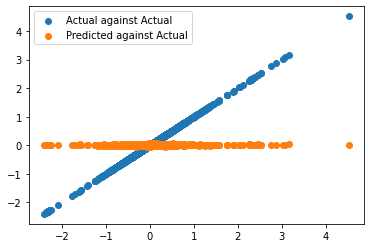

In [53]:
import matplotlib.pyplot as plt 

  
# plot lines 
plt.scatter(y_test, y_test, label = "Actual against Actual") 
plt.scatter(y_test, y_pred, label = "Predicted against Actual") 
plt.legend() 
plt.show()